In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/gdrive/MyDrive/archive.zip', 'r') as zf:
    zf.extractall()

In [ ]:
from pathlib import Path

DATA_ROOT = Path('/content/leapGestRecog')

In [ ]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

Шаг 1. Подготовка данных

Создадим объекты для необходимых трансформаций нашего датасета:

In [ ]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([128, 128]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           # Random 90 degree rotations
                         tt.RandomRotation(30),               # Random 30 degree rotations
                         tt.ToTensor(),                      # Cast to tensor
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])


In [ ]:
import re

def gest_label_encoding(gest):
    code = re.findall('^\d*', gest)[0]
    return int(code)-1

def make_df_from_files(parent_dir_path=DATA_ROOT):
    result = list()
    for person in os.listdir(parent_dir_path):
        person_path = parent_dir_path.joinpath(person)
        for gest in os.listdir(person_path):
            gest_path = person_path.joinpath(gest)
            for img in os.listdir(gest_path):
                result.append([img, gest_path.joinpath(img), gest_label_encoding(gest), person])
                    
    return result

In [ ]:
gest_df = pd.DataFrame(make_df_from_files(), columns=('img', 'path', 'gest', 'person'))
gest_df.head(5)

,img,path,gest,person
0,frame_08_06_0106.png,/content/leapGestRecog/08/06_index/frame_08_06...,5,08
1,frame_08_06_0118.png,/content/leapGestRecog/08/06_index/frame_08_06...,5,08
2,frame_08_06_0190.png,/content/leapGestRecog/08/06_index/frame_08_06...,5,08
3,frame_08_06_0095.png,/content/leapGestRecog/08/06_index/frame_08_06...,5,08
4,frame_08_06_0146.png,/content/leapGestRecog/08/06_index/frame_08_06...,5,08


In [ ]:
gest_df['gest'].unique()

array([5, 0, 9, 8, 1, 7, 4, 2, 3, 6])

In [ ]:
len(gest_df)

20000

In [ ]:
class LeapGests(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        
        self.image_paths = self.data.iloc[:, 1]
        self.image_gest = self.data.iloc[:, 2]
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        
        if self.preprocessing is not None:
            img = self.preprocessing(img)
        
        gest = self.image_gest[idx]

        return img, gest

Определим размер батча:

In [ ]:
batch_size = 64

И создадим наши даталоадеры:

In [ ]:
train_dataset = LeapGests(gest_df, train_tfms)
valid_dataset = LeapGests(gest_df, test_tfms)

In [ ]:
#разделим на трейн и тест
torch.manual_seed(1)

val_split = 0.25
split = int(len(gest_df) * val_split)
indices = torch.randperm(len(gest_df))

train_ds = torch.utils.data.Subset(train_dataset, indices[split:])
test_ds = torch.utils.data.Subset(valid_dataset, indices[:split])

len(train_ds), len(test_ds)

(15000, 5000)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=1)

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


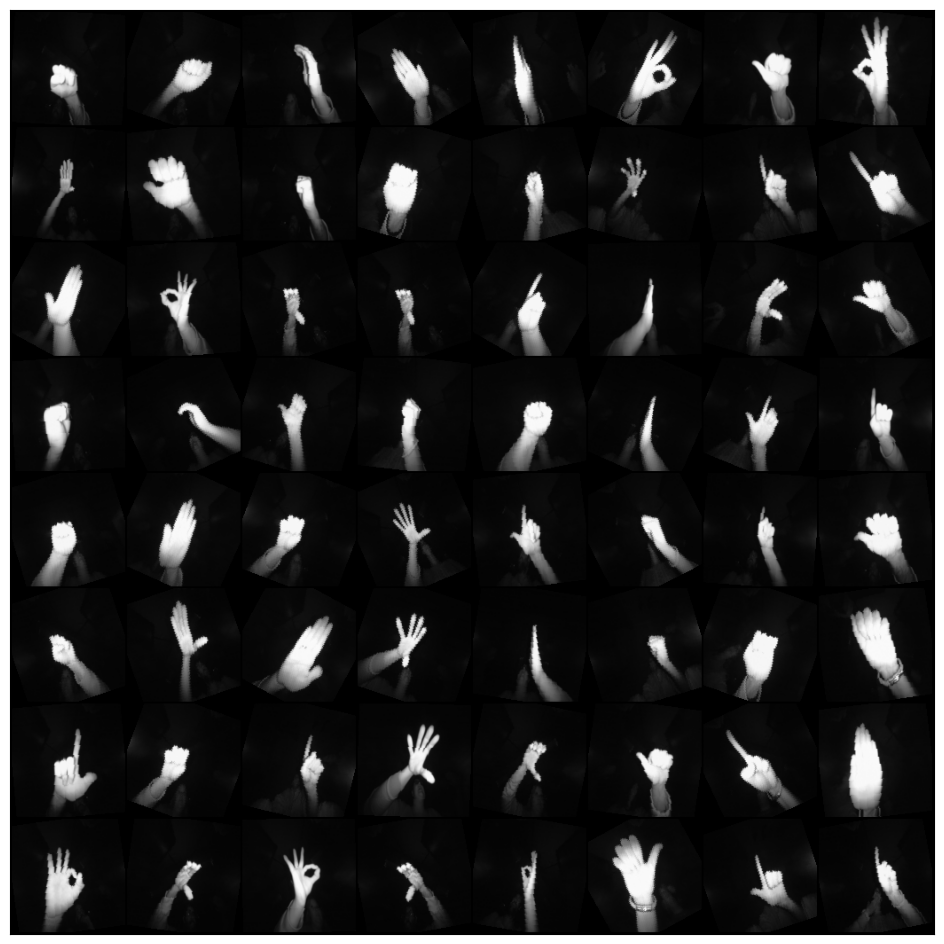

In [ ]:
show_batch(train_loader)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Воспользуемся функциями написанными выше:

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
test_dl = DeviceDataLoader(valid_loader, device)

Шаг 2. Модель ResNet50


In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchvision import models
from torchsummary import summary

resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 69.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
for param in list(resnet.parameters())[:]:
  param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=10)
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Шаг 3. Обучение

In [ ]:
torch.cuda.empty_cache()
history = []

epochs = 15
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), max_lr, weight_decay=weight_decay)

In [ ]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

15 epochs, 313 total_steps per epoch


In [ ]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        
        
        optimizer.zero_grad()
        
        outputs = resnet(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  0.6675185535948116
Epoch 2, loss:  0.35227343316276233
Epoch 3, loss:  0.29355424304549305
Epoch 4, loss:  0.2637295866974246
Epoch 5, loss:  0.24213151581371173
Epoch 6, loss:  0.23255054376567133
Epoch 7, loss:  0.21536480037929912
Epoch 8, loss:  0.20489126548599512
Epoch 9, loss:  0.20189603328847658
Epoch 10, loss:  0.18585557903582678
Epoch 11, loss:  0.16786978979365894
Epoch 12, loss:  0.17937818907510739
Epoch 13, loss:  0.16940212148589828
Epoch 14, loss:  0.16808604952483513
Epoch 15, loss:  0.1565325258853146


Посмотрим на нашу ошибку в процессе обучения:

Text(0.5, 1.0, 'losses vs. No. of epochs')

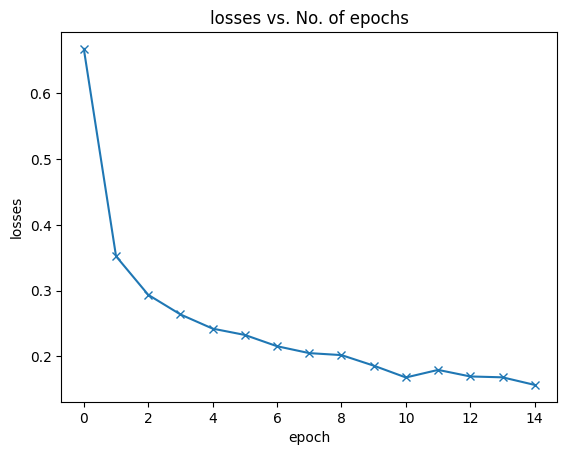

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

Сохраним нашу модель:

In [ ]:
torch.save(resnet, '/content/detection_model.pth')

Теперь давайте загрузим ее и будем использовать:

In [ ]:
resnet = torch.load('/content/detection_model.pth')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Прогоним нашу нейронную сеть через тестовый датасет:

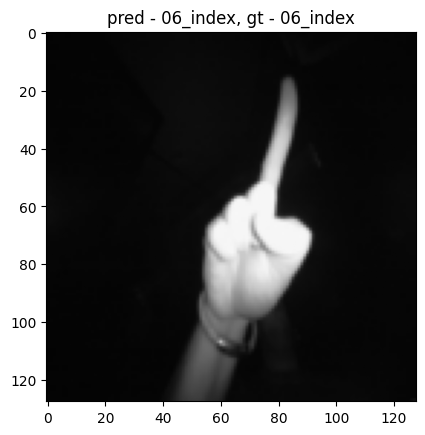

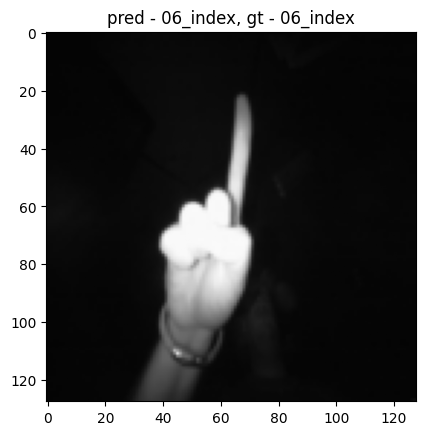

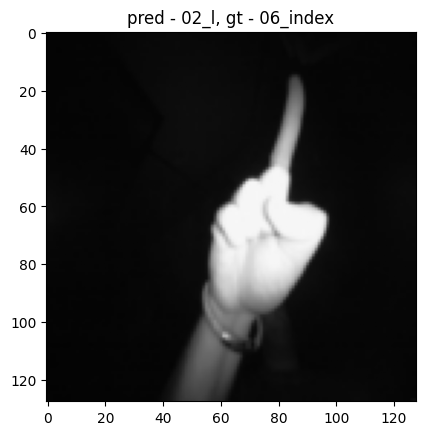

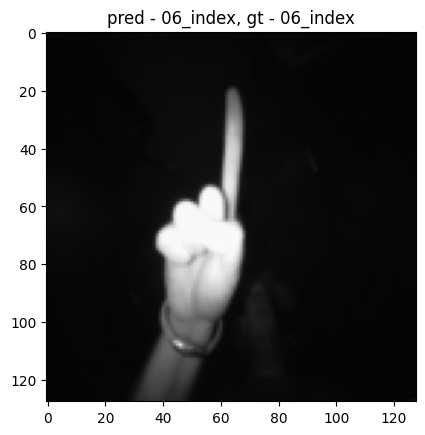

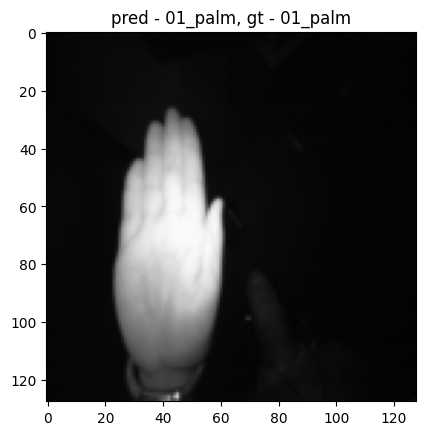

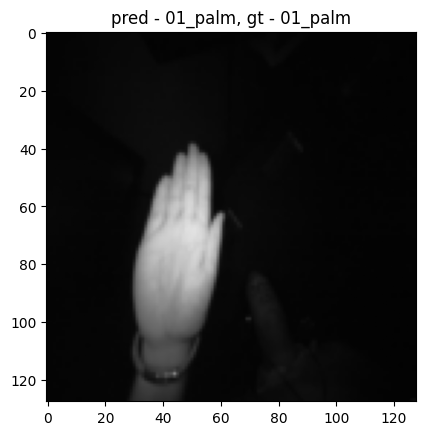

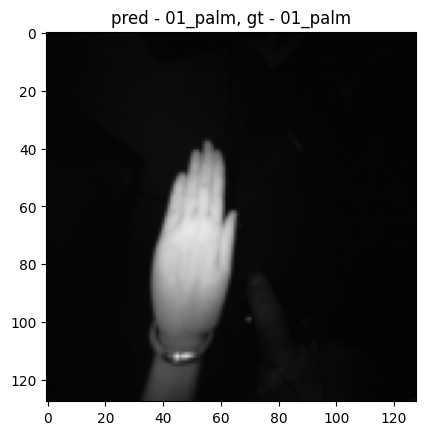

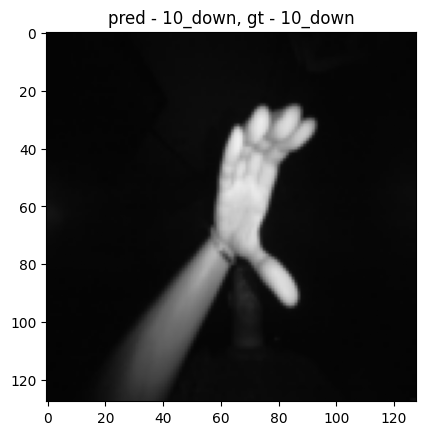

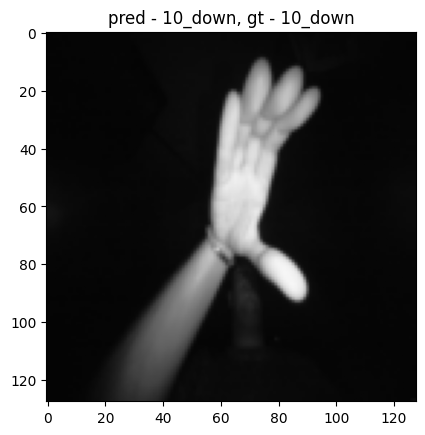

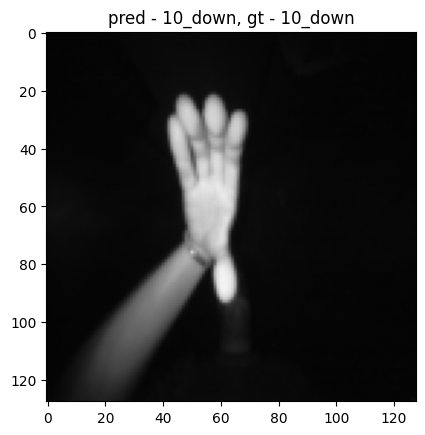

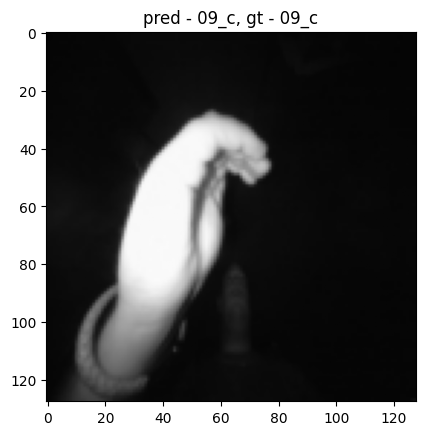

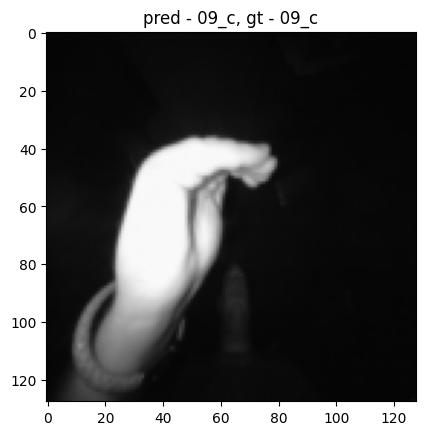

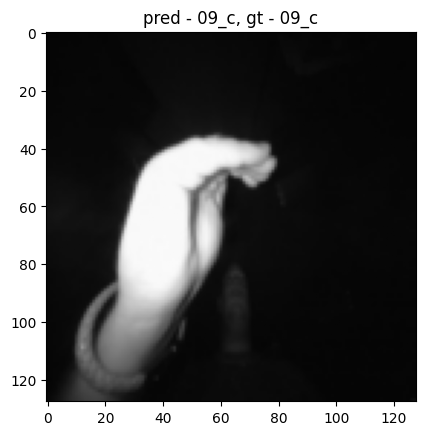

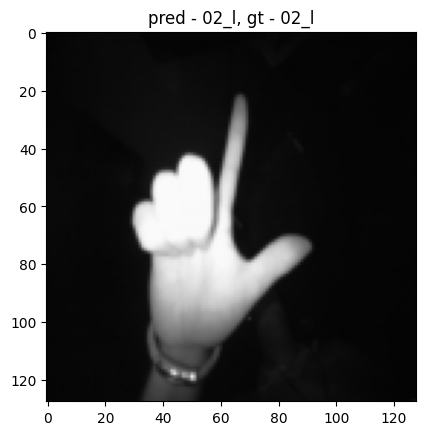

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {CLASSES_NAME[outputs[0].argmax()]}, gt - {CLASSES_NAME[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>15:
            break

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

  

  return filename

<IPython.core.display.Javascript object>

Saved to photo4.jpg


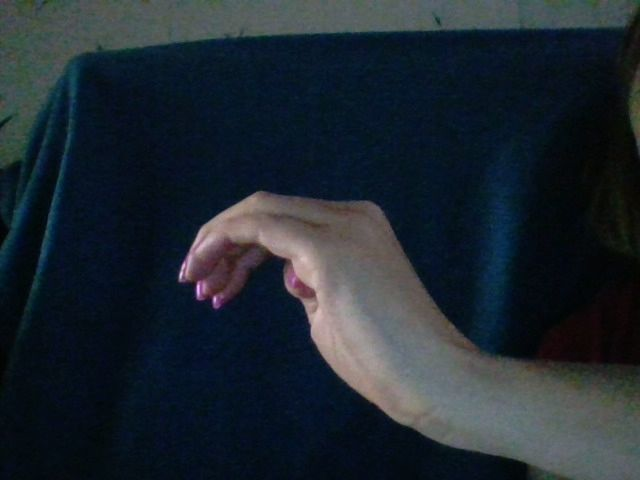

In [ ]:
from IPython.display import Image
try:
  filename = take_photo('photo4.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Automatically created module for IPython interactive environment


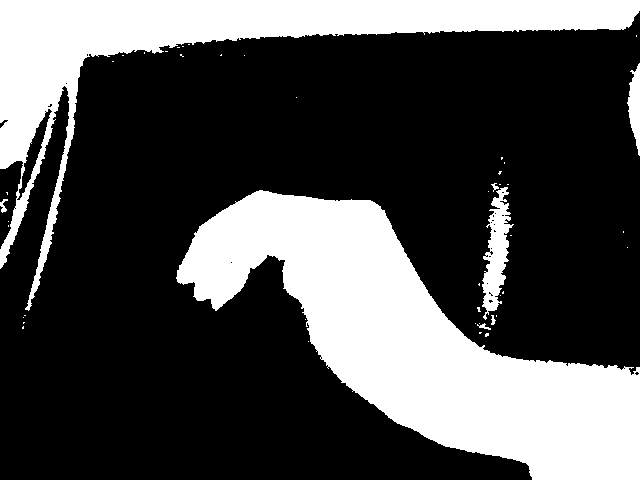

In [ ]:
import sys
import numpy as np
import cv2 
from google.colab.patches import cv2_imshow

# параметры цветового фильтра
hsv_min = np.array((2, 28, 65), np.uint8)
hsv_max = np.array((26, 238, 255), np.uint8)

if __name__ == '__main__':
    print(__doc__)

    fn = 'photo4.jpg' # путь к файлу с картинкой
    img = cv2.imread(fn)

    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
       
    ret, thresh = cv2.threshold(imgray, 30, 255, cv2.THRESH_BINARY)
# визуализировать двоичное изображение
    cv2_imshow(thresh)
    cv2.waitKey(0)
    cv2.imwrite('image_thres4.jpg', thresh)
    cv2.destroyAllWindows()   

    #contours, hierarchy = cv.findContours(threshold, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    #cv.drawContours(img, contours,-1,(0,255,0),3)
    #cv2_imshow(img) # выводим итоговое изображение в окно

    #cv.waitKey()
    #cv.destroyAllWindows()

In [ ]:
gest = {'img': ['image_thres1.jpg', 'image_thres2.jpg', 'image_thres3.jpg', 'image_thres4.jpg'], 
        'path': ['/content/image_thres1.jpg', '/content/image_thres2.jpg', '/content/image_thres3.jpg', '/content/image_thres4.jpg'], 
        'gest': [9, 5, 6, 8]}
df = pd.DataFrame(gest)
df

,img,path,gest
0,image_thres1.jpg,/content/image_thres1.jpg,9
1,image_thres2.jpg,/content/image_thres2.jpg,5
2,image_thres3.jpg,/content/image_thres3.jpg,6
3,image_thres4.jpg,/content/image_thres4.jpg,8


In [ ]:
test_dataset = LeapGests(df, test_tfms)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1)

In [ ]:
dl = DeviceDataLoader(test_loader, device)

In [ ]:
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

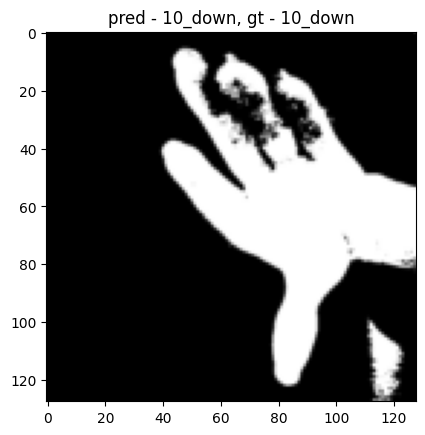

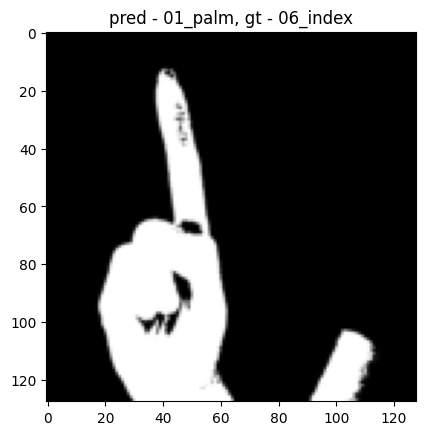

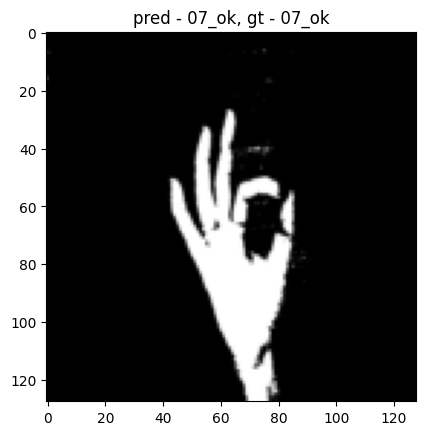

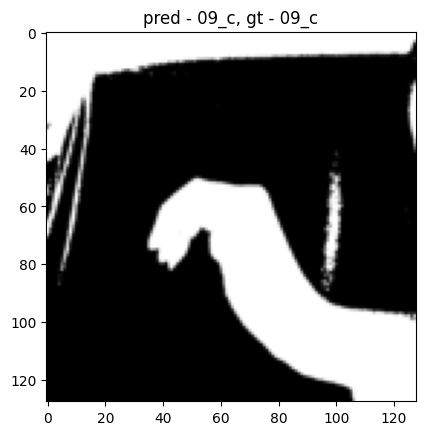

In [ ]:
from PIL import Image

with torch.no_grad():
    for i, data in enumerate(dl):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {CLASSES_NAME[outputs[0].argmax()]}, gt - {CLASSES_NAME[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break   

### 3 из 4х совпало